# Game Data cleaning and exploration
The goal with this notebook is to provide a basic analysis of the games dataset.

## Data loading and cleaning

In [304]:
import warnings
warnings.filterwarnings('ignore')

In [305]:
import pandas as pd
from ast import literal_eval
import os
import seaborn as sns
df = pd.read_csv('midi_dataframe.csv', parse_dates=[11])
num_midis_before = len(df)
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(num_midis_before,
        len(df.groupby(['tgdb_platform', 'tgdb_gametitle'])),
        (df.tgdb_gametitle.notnull().sum())))
df.head()

There is 31685 midi files, from 3388 games, with 31249 midis matched with tgdb


,brand,console,game,title,file_name,tgdb_genres,tgdb_id,tgdb_developer,tgdb_publisher,tgdb_platform,tgdb_gametitle,tgdb_releasedate,tgdb_players,tgdb_rating,tgdb_esrb,tgdb_overview
0,Nintendo,NES,10-Yard Fight,Kick Off,b5da1581fd2b425122446a638363a28296aee817.mid,['Sports'],317.0,Nintendo,Nintendo,Nintendo Entertainment System (NES),10-Yard Fight,1985-10-18,2,4.5714,E - Everyone,The game is viewed in a top-down perspective a...
1,Miscellaneous,Arcade,1941: Counter Attack,Krote Armor Stage,efe29bdfc97d46a327467ea5d6e36bff6edc4223.mid,['Shooter'],2434.0,Capcom,Capcom,Arcade,1941: Counter Attack,1990-02-01,2,6.3333,NaN,The goal is to shoot down enemy airplanes and ...
2,Miscellaneous,Arcade,1941: Counter Attack,Level 6 Section 1,a356a1fd4960e4faa875c13bf7d03cfef3255cfd.mid,['Shooter'],2434.0,Capcom,Capcom,Arcade,1941: Counter Attack,1990-02-01,2,6.3333,NaN,The goal is to shoot down enemy airplanes and ...
3,Computer Systems,Commodore 64,1942,Main Theme,52e23ff501c107b2055d543d8249e96f43eab97e.mid,['Shooter'],6434.0,NaN,Elite,Commodore 64,1942,NaT,1,7.0000,NaN,1942 is set in the Pacific theater of World Wa...
4,Nintendo,NES,1943,Assault on Surface Forces B,26634701e919c25fddd82b00d63d75e1dedb5326.mid,['Shooter'],1018.0,Capcom,Capcom,Nintendo Entertainment System (NES),1943: The Battle of Midway,1987-06-01,2,4.5000,E - Everyone,The game is set in the Pacific theater of Worl...


We first only keep only files matched with tgdb and check that every midi file is only present once, if not we drop the rows.

In [306]:
num_dup = df.duplicated(subset='file_name').sum()
df.drop_duplicates(subset='file_name', inplace=True)
print('There was %d duplicated midi files, %d midis left'%(num_dup, len(df)))

There was 2 duplicated midi files, 31683 midis left


Since we are interested in the genre, we only keep midis that have one.

In [307]:
num_genres_na = df.tgdb_genres.isnull().sum()
df.dropna(subset=['tgdb_genres'], inplace=True)
print("We removed %d midis, %d midis left"%(num_genres_na, len(df)))

We removed 436 midis, 31247 midis left


Then, there are some categories, such as Medleys or Piano only that are not interesting.

There is also a big "remix" scene on vgmusic, so we also remove those.

In [308]:
categories_filter = df.console.isin(['Medleys', 'Piano Only'])
remix_filter = df.title.str.contains('[Rr]emix')

df = df[~categories_filter & ~remix_filter]
print('We removed %d midis from Medleys and Piano categories'%categories_filter.sum())
print('We removed %d midis containing "remix" in their title'%remix_filter.sum())
print('%d midis left'%len(df))

We removed 872 midis from Medleys and Piano categories
We removed 1860 midis containing "remix" in their title
28537 midis left


There often exists several versions of the same midi file, most of the time denoted by 'title (1)', 'title (2)', etc.

We also consider removing those, but keeping only the one with the highest value, or if there are several with the same title, we randomly keep one.

In [309]:
num_midis_before = len(df)

df_stripped = df.copy()
df_stripped.title = df.title.str.replace('\(\d+\)', '').str.rstrip()
df_stripped['rank'] = df.title.str.extract('\((\d+)\)', expand=False)
df = df_stripped.sort_values(by='rank', ascending=False).groupby(['brand', 'console', 'game', 'title']).first().reset_index()
print("We removed %d midis, %d midis left"%(num_midis_before-len(df), len(df)))

We removed 6358 midis, 22179 midis left


We also check if the midis files are valid using mido and trying to load them.

In [329]:
from mido import MidiFile

bad_midis = []
for file in df['file_name']:
    try:
        midi = MidiFile("full/" + file)
    except:
        bad_midis.append(file)
df = df.loc[df.file_name.apply(lambda x: x not in bad_midis)]
print("We removed %d midis, %d midis left"%(len(bad_midis), len(df)))

We removed 117 midis, 22062 midis left


The final numbers after preliminary data cleaning are:

In [330]:
num_games = len(df.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df),
        num_games,
        (df.tgdb_gametitle.notnull().sum())))

There is 22062 midi files, from 3237 games, with 22062 midis matched with tgdb


## Data Exploration

## General statistics
We first begin by some general statistics about the dataset

In [311]:
print('There is %d platforms'%df.tgdb_platform.nunique())

There is 62 platforms


Number of games per platform statistics:

,0
count,62.000000
mean,52.306452
std,83.463664
min,1.000000
25%,3.000000
50%,15.000000
75%,67.500000
max,393.000000


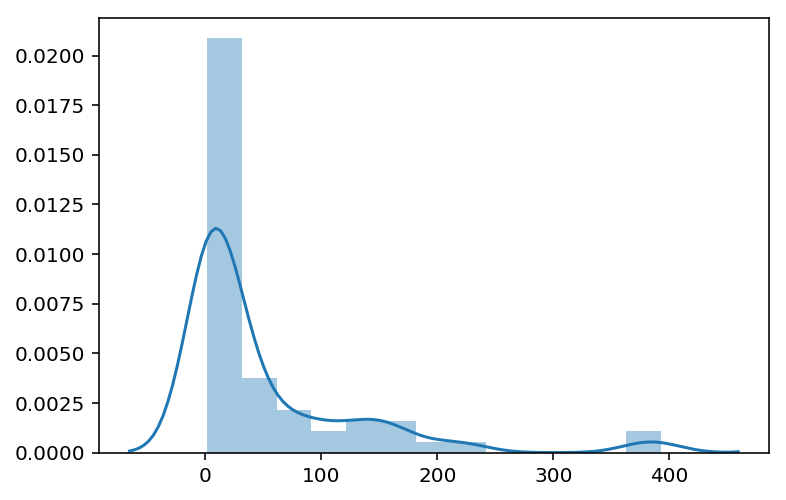

In [312]:
sns.distplot(df.drop_duplicates(subset=['tgdb_platform', 'tgdb_gametitle']).groupby('tgdb_platform').size().to_frame())
df.drop_duplicates(subset=['tgdb_platform', 'tgdb_gametitle']).groupby('tgdb_platform').size().to_frame().describe()

Number of midis per platform statistics:

,0
count,62.000000
mean,357.725806
std,716.339721
min,1.000000
25%,8.000000
50%,54.000000
75%,304.750000
max,4155.000000


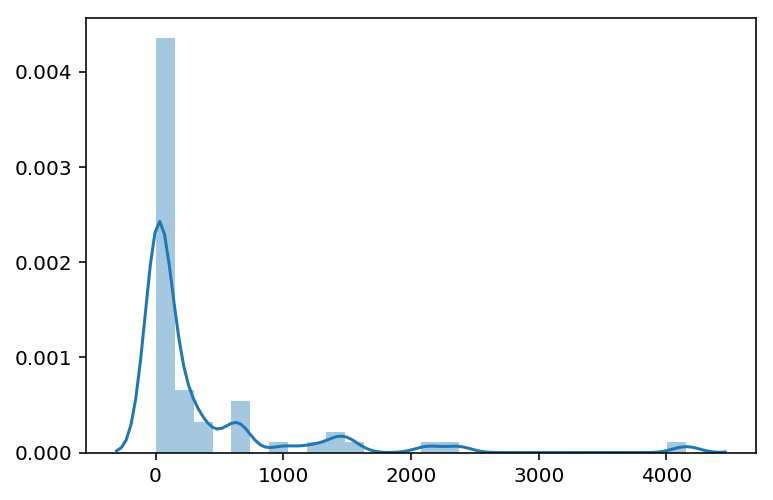

In [313]:
sns.distplot(df.groupby('tgdb_platform').size().to_frame())
df.groupby('tgdb_platform').size().to_frame().describe()

Number of midi per game statistics:

,0
count,3243.000000
mean,6.839038
std,11.937013
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,147.000000


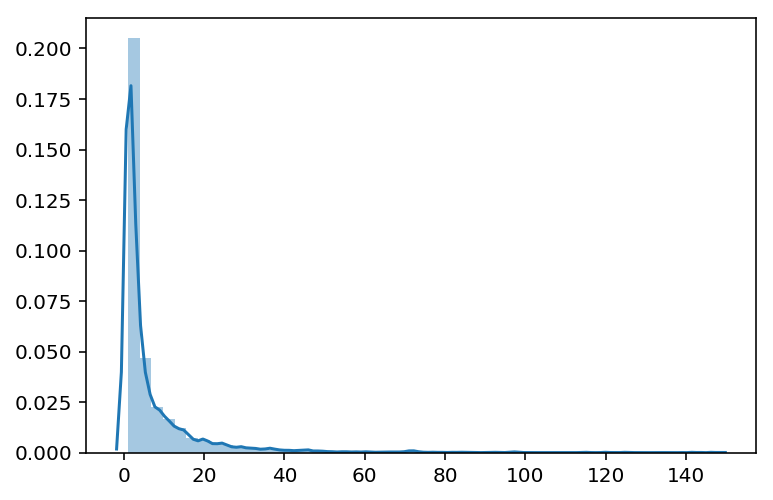

In [314]:
sns.distplot(df.groupby(['tgdb_platform', 'tgdb_gametitle']).size().to_frame())

df.groupby(['tgdb_platform', 'tgdb_gametitle']).size().to_frame().describe()

Most of the data we have follow power laws.

### Genres analysis
We currently had list of genres, for more convenience, we rework the dataframe to make several row of a midi if it had several genres.

In [315]:
genres = df.tgdb_genres.map(literal_eval, 'ignore').apply(pd.Series).stack().reset_index(level=1, drop=True)
genres.name = 'tgdb_genres'
genres_df = df.drop('tgdb_genres', axis=1).join(genres)

print("There is %d different genres"%genres_df.tgdb_genres.nunique())

There is 19 different genres


Here follows the percentage of games belonging to each genre and of midis for each genres.

In [316]:
genres_df.drop_duplicates(subset=['tgdb_platform', 'tgdb_gametitle'])\
    .groupby(['tgdb_genres']).size().to_frame()\
    .sort_values(0, ascending = False)/num_games*100

,0
tgdb_genres,
Action,35.121801
Role-Playing,10.299106
Platform,9.435708
Shooter,9.189023
Fighting,8.479803
Adventure,6.753006
Puzzle,5.488745
Racing,4.378662
Sports,4.286155


In [317]:
genres_df.groupby(['tgdb_genres']).size().to_frame().sort_values(0, ascending = False)/len(df)*100

,0
tgdb_genres,
Action,38.432752
Role-Playing,29.834528
Platform,22.724199
Adventure,21.651111
Shooter,10.135714
Fighting,8.332206
Puzzle,6.686505
Sports,5.058839
Strategy,4.950629


The number of genres is 19, and could be reduced to 10 if we consider only the genres for which we have at least 3% dataset coverage or 6 if we consider only the genres for which we have at least 9% dataset coverage.

# analysing Midis using MIDO

To just get a quick idea of the size of the midi files, we measure the length of 500 randomly sampled ones.

In [302]:
from mido import MidiFile

#removing problematic midis

average_length = 0
num_fails = 0
#to speed tup computation time, only the first 500 midis are considered.
for filename in df.sample(500)['file_name']:
    try:
        midi = MidiFile("full/" + filename)
        average_length += midi.length
    except:
        num_fails += 1

average_length /= 500
average_length

OSError: data byte must be in range 0..127